In [1]:
import datetime
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
import glob
import pandas as pd
import cv2
from backbone import EfficientDetBackbone
from efficientdet.dataset import CocoDataset, Resizer, Normalizer, Augmenter, collater


from shapely.geometry import Polygon
from pyproj import Transformer
import ast
import json
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
def geo_coords(box, x_translation, y_translation, geo_data, center=False):
  """
  Gets coordinates in epsg:4326 format (google maps) of bounding box
  If center, return only coordinate of center of bounding box
  Params:
    Box: [xmin, ymin, xmax, ymax]
  """
  transformer = Transformer.from_crs(geo_data['crs'], 'epsg:4326')
  if center:
    center_x, center_y = (box[2] + box[0])//2 + x_translation, (box[3] + box[1])//2 + y_translation
    new_coords = np.array(geo_data['transform']).reshape((3,3)) @ np.array( [center_x, center_y, 1])

    return transformer.transform(new_coords[0], new_coords[1])

  else:
    new_box = np.array([[x_translation + box[0], y_translation + box[1], 1],
            [x_translation + box[2], y_translation + box[3], 1]])
    new_coords = np.array(geo_data['transform']).reshape((3,3)) @ new_box.T

    return transformer.transform(new_coords[0], new_coords[1])

def get_list_polygon(xs, ys):
    xs, ys = sorted(xs), sorted(ys)
    return [[ys[0], xs[0]], [ys[1], xs[0]], [ys[1], xs[1]], [ys[0], xs[1]]]


input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]

class EvaluationSet(object):
    def __init__(self, img_path, set_name='val', compound_coeff=1,
                 mean=[0.3470, 0.3371, 0.3029], std=[0.2138, 0.2029, 0.1984]):
        
        self.imgs = sorted(glob.glob(f'{img_path}/images/{set_name}/*'))
        self.df = pd.read_csv(f'{img_path}/{set_name}.csv')
        self.mean = mean
        self.std = std
        self.compound_coeff = compound_coeff
        self.max_size = input_sizes[compound_coeff]
        
    def __getitem__(self, idx):
        return preprocess(self.imgs[idx], max_size=self.max_size, mean=self.mean, std=self.std)
    
    def __len__(self):
        return len(self.imgs)

In [4]:
import tqdm
        
def compute_coordinates(dataset, model, device, nms_threshold=0.45, threshold=0.2, set_name='val'):
    results = []
    json_results = []
    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()
    
    for idx, (ori_imgs, framed_imgs, framed_metas) in enumerate(tqdm.tqdm(dataset)):

        x = torch.from_numpy(framed_imgs[0])

        x = x.to(device)

        x = x.unsqueeze(0).permute(0, 3, 1, 2)
        features, regression, classification, anchors = model(x)

        preds = postprocess(x,
                            anchors, regression, classification,
                            regressBoxes, clipBoxes,
                            threshold, nms_threshold)
        
        if not preds:
            continue

        preds = invert_affine(framed_metas, preds)[0]
        
        md = dataset.df.loc[idx]
        scores = preds['scores']
        class_ids = preds['class_ids']
        rois = preds['rois']
        md['transform'] = ast.literal_eval(md['transform'].replace("'", '"'))
        if rois.shape[0] > 0:

            bbox_score = scores

            for roi_id in range(rois.shape[0]):
                score = float(bbox_score[roi_id])
                label = int(class_ids[roi_id])
                box = rois[roi_id, :]
                image_result = {
                    'image_id': idx,
                    'category_id': label + 1,
                    'score': float(score),
                    'bbox': box.tolist(),
                }
                json_results.append(image_result)
                xs, ys = geo_coords(box, md['x_offset'], md['y_offset'], md, center=False)
                results.append((get_list_polygon(xs, ys), score, label))
    
    filepath = f'coordinate_results/{set_name}_bbox_results.json'
    if os.path.exists(filepath):
        os.remove(filepath)
    json.dump(json_results, open(filepath, 'w'), indent=4)


    return results
                
def load_model(weights_path, compound_coef, device, num_classes=1, 
               ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)], scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]):
    model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=num_classes,
                                 ratios=ratios,
                                 scales=scales)
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
    model.requires_grad_(False)
    model.eval()
    model.to(device)
    return model

## Compute model values

In [7]:
weights = 'logs/cleancoolingTowers_negsamples/images/efficientdet-d2_'
compound_coeff = 1

model = load_model(weights, compound_coeff, device, num_classes=1)
dataset = EvaluationSet('../datasets/cleancoolingTowers_negsamples//', set_name='train',
                        compound_coeff=compound_coeff)
results = compute_coordinates(dataset, model, device, set_name='d1')

  0%|          | 0/5276 [00:00<?, ?it/s]/home/m.esguerra/.pyenv/versions/myenv/envs/finderenv/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 5276/5276 [06:04<00:00, 14.49it/s]


In [5]:
# import pickle
# with open(f'coordinate_results/coords_d1_second_stage.pkl', 'wb') as f:
#         pickle.dump(results, f)


## Compute second stage

In [14]:
def load_targets(annot_path, set_name='val'):
    df = pd.read_csv(os.path.join(annot_path, f'{set_name}.csv')
                     , index_col=0).sort_values(['directory', 'file']).reset_index(drop=True)
    df['width'], df['height'] = 256, 256
    coordinate_list = []
    for file in sorted(os.listdir(os.path.join(annot_path,'labels', set_name))):
        try:
            df_res = pd.read_csv(os.path.join(annot_path, 'labels', set_name, file), header=None, sep=' ')
            num = int(file.replace('.txt', ''))
            md = df.iloc[num]
            md['transform'] = ast.literal_eval(md['transform'].replace("'", '"'))
            for i, row in df_res.iterrows():
                width, height = row[3]* md['width'], row[4] * md['height']
                center_x, center_y = row[1] * md['width'], row[2] * md['height']
                box = [center_x- width//2, center_y - height//2, center_x + width // 2, center_y + width //2]
                xs, ys = geo_coords(box, md['x_offset'], md['y_offset'], md, center=False)
                coordinate_list.append((get_list_polygon(xs, ys), row[0]))
        except Exception as e:
            print(e)
            pass
    return coordinate_list
    
compute = True
if compute:
    directory = 'cleancoolingTowers_active_distinguish'
    coord_list = load_targets(f'../datasets/{directory}', )
    import pickle
    with open(f'../datasets/{directory}/val_coords.txt', 'wb') as f:
        pickle.dump(coord_list, f)

/home/m.esguerra/.pyenv/versions/myenv/envs/finderenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file
No columns to parse from file


In [25]:
def get_confidence_evol(gdf_in, gdf_targets, confidences=np.arange(0.1, 1, 0.04)):
    p_ls, r_ls = [], []
    for confidence in confidences:
        gdf_preds = gdf_in[gdf_in[0] > confidence]
        preds_match = geopandas.sjoin(gdf_preds, gdf_targets, how='left', op='within').drop_duplicates('geometry')
        target_match = geopandas.sjoin(gdf_preds, gdf_targets, how='right', op='within').drop_duplicates('geometry')
        tp = target_match[target_match.index_left.notnull()].drop_duplicates('index_left').shape[0]
        fp = preds_match[preds_match.index_right.isna()].shape[0]
        fn = target_match[target_match.index_left.isna()].shape[0]
        print(tp, fp, fn)
        p = tp/(tp+fp) if (tp+fp) > 0 else 1
        r = tp/(tp+fn) if (tp + fn) > 0 else 0
        p_ls.append(p)
        r_ls.append(r)
    
    return p_ls, r_ls

In [18]:
import geopandas
from shapely.geometry import Polygon
with open('../Yet-Another-EfficientDet-Pytorch/coordinate_results/coords_d1_second_stage.pkl', 'rb') as f:
    preds = pickle.load(f)
confidences = [p[1] for p in preds]
labels = [p[2] for p in preds]
polygons_preds = [Polygon(p[0]).centroid for p in preds]
preds = geopandas.GeoDataFrame(confidences, geometry=polygons_preds)
preds['labels'] =labels

In [22]:
with open('../datasets/cleancoolingTowers_active_distinguish/val_coords.txt', 'rb') as f:
    coord_list = pickle.load(f)

polygon_target = [Polygon(p[0]) for p in coord_list]
labels = [p[1] for p in coord_list]
gdf_targets = geopandas.GeoDataFrame(geometry=polygon_target)
gdf_targets['labels'] = labels
gdf_targets['labels'] =gdf_targets['labels'].astype(int)

76 199 0
76 199 0
76 199 0
76 199 0
76 199 0
76 199 0
76 167 0
75 132 0
71 109 0
71 94 2
70 78 3
67 63 7
62 55 13
58 47 15
49 35 26
41 25 38
28 17 52
19 11 67
16 5 71
7 2 82
2 1 92
1 1 93
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94
0 0 94


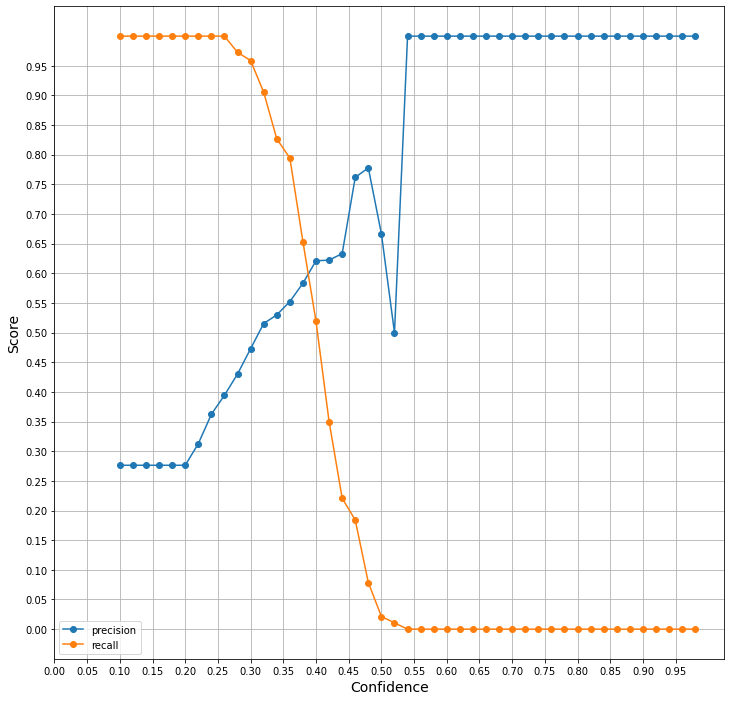

In [26]:
fig, ax = plt.subplots(figsize=(12,12))
confidences=np.arange(0.1, 1, 0.02)
p_ls, r_ls = get_confidence_evol(preds[preds.labels >0], gdf_targets[gdf_targets.labels>0], confidences)
ax.plot(confidences, p_ls, label='precision', marker='o')
ax.plot(confidences, r_ls, label='recall', marker='o')
ax.legend()
ax.set_xlabel('Confidence', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_yticks(np.arange(0,1, 0.05));
ax.set_xticks(np.arange(0,1, 0.05))
ax.grid()